In [1]:
# importing matplotlib modules 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import scipy.ndimage as im
import math
import numpy as np
import skimage.io
import random
from sklearn.cluster import KMeans
import pandas as pd
from skimage.draw import polygon2mask
import snake_functions as S

In [2]:
patch_size = 5

In [3]:
def im2col(A, BSZ, stepsize=1):
    # Parameters
    m,n = A.shape
    s0, s1 = A.strides    
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

In [4]:
def ndim2col(A, BSZ, stepsize=1):
    if(A.ndim == 2):
        return im2col(A, BSZ, stepsize)
    else:
        r,c,l = A.shape
        patches = np.zeros((l*BSZ[0]*BSZ[1],(r-BSZ[0]+1)*(c-BSZ[1]+1)))
        for i in range(l):
            patches[i*BSZ[0]*BSZ[1]:(i+1)*BSZ[0]*BSZ[1],:] = im2col(A[:,:,i],BSZ,stepsize)
        return patches

In [5]:
def perpendicular( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def normalize(a):
    a = np.array(a)
    return a/np.linalg.norm(a)

In [6]:
def smoothing_matrix(alpha,beta,size):
    m1 = np.diag([-2]*size)
    m2 = np.diag([-6]*size)
    for i in range(0,size):
        if i==size-1:
            j=-1
        elif i==size-2:
            j=-2
        else:
            j=i    
        m1[i,j+1] = 1
        m1[i,i-1] = 1
        m2[i,j+1] = 4
        m2[i,i-1] = 4
        m2[i,j+2] = -1
        m2[i,i-2] = -1
    
    return alpha*m1 + beta*m2

In [7]:
# creating initial snake
def init_snake(x_center, y_center, radius, no_points):
    r = radius
    snake = np.zeros([no_points,2])
    for i in range(0,no_points):
        angle = (2*math.pi)/no_points
        j = x_center + r * math.cos(angle*i)
        k = y_center + r * math.sin(angle*i)
        snake[i,0] = int(j)
        snake[i,1] = int(k)


    return snake.astype('int')

In [8]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

In [274]:
def compute_normals(snake):
    n = np.zeros_like(snake)
    a = np.zeros_like(snake)
    s_next = np.roll(snake, -1, axis=0) # next
    n[:,0] =   s_next[:,1] - snake[:,1]
    n[:,1] = -(s_next[:,0] - snake[:,0])

    n = n / np.linalg.norm(n, axis=1)[:,None]
    n_prev = np.roll(n, 1, axis=0)
    a = (n+n_prev)/2
    a[np.isnan(a)]=0
    return a

In [192]:
def deform(img, kmeans, index, patch_size, snake, stepsize, alpha, beta, its):

    s_len = len(snake)
    
    # predict nearest cluster
    if len(img.shape) == 2:
        patches = im2col(img,[patch_size,patch_size],stepsize=1)
    elif len(img.shape) == 3:
        patches = ndim2col(img,[patch_size,patch_size],stepsize=1)
    predicted = kmeans.predict(patches.transpose())
    
    #regularization mTRIX
    B_int = np.linalg.inv((np.diag([1]*s_len)-smoothing_matrix(alpha,beta,s_len)))

    for iterations in range(0,its):
        
        # creating 'true' label of each patch
        mask = polygon2mask(img.shape[0:2],np.flip(snake))
        
        labels = mask
        labels = labels.astype(np.float)
        if len(img.shape) == 2:
            patches_labels = im2col(labels,[patch_size,patch_size],stepsize=1)
        elif len(img.shape) == 3:
            patches_labels = ndim2col(labels,[patch_size,patch_size],stepsize=1)
        patches_labels = patches_labels[:,index]
        
        # label 0 if more than half of pixels are outside snake, 1 otherwise
        labels = sum(patches_labels) > ((patch_size**2)/2)
        
        # cluster of each patch with "true" label
        data = np.array([kmeans.labels_,labels]).transpose()
        
        # probability of classes for each cluster
        probs = pd.DataFrame(data, columns=['cluster','label_1']).groupby('cluster').mean()
        probs['label_0'] = 1-probs['label_1']
        
        
        # probability of class 1 for all patches
        prob_pred = np.array(probs.iloc[predicted].label_1).reshape(img.shape[0]-patch_size+1,img.shape[1]-patch_size+1)

        snake_pixel = np.round(snake).astype('int')
        
        # probability of class 1 for each snake point
        values = prob_pred[snake_pixel[:,1],snake_pixel[:,0]]
        values[values==1] = 0.9999999
        values[values==0] = 0.0000001
        
        # probability of class 1 inside and outside snake
        mask_reduced = mask[int(patch_size/2):int(-(patch_size/2)),int(patch_size/2):int(-(patch_size/2))]
        

        #prob_in = np.mean(prob_pred[mask_reduced==1])
        #prob_out = np.mean(prob_pred[mask_reduced==0])
    

        # force for each point in snake
        
        #force = (prob_in-prob_out)*(values - threshold)
        force = np.log((sum(sum(mask_reduced==0))*values)/(sum(sum(mask_reduced==1))*(1-values)))
        # force need to be in matrix shape
        force_matrix = np.diag(force)
        
        # calculating normals
        normals = compute_normals(snake)
       
        
        # transform snake
        snake = B_int.dot(snake + stepsize * force_matrix.dot(normals))

        snake = S.distribute_points(np.transpose(snake))

        snake = S.remove_intersections(snake)

        snake = np.transpose(snake)
        
        # Visualize
        cv2.imshow("mask", mask.astype(float))
        cv2.imshow("color probs", prob_pred)
        vis_snake(img.astype('uint8'), snake, wait=1, title="Original")

    
    
    return snake, force, normals, prob_pred, mask_reduced, mask

In [11]:
def plot_dictionary(cluster_centers, rows, cols, patch_shape=(), spacing=3):
    if(patch_shape==()):
        s = int(np.sqrt(cluster_centers.shape[1]))
        patch_shape = (s,s)

    h = patch_shape[0]+spacing
    w = patch_shape[1]+spacing
        
    dict_img = np.zeros((rows*w + spacing,
                         cols*w + spacing))
    
    if len(patch_shape) == 2:
        cluster_centers = cluster_centers.reshape(rows,cols,patch_shape[0],patch_shape[1])
    else:
        cluster_centers = cluster_centers.reshape(rows,cols,patch_shape[0],patch_shape[1], patch_shape[2])
        dict_img = np.zeros((rows*w + spacing,
                             cols*w + spacing,3))
    
    
    for r in range(rows):
        for c in range(cols):
            y = spacing + r*h
            x = spacing + c*w
            if len(patch_shape)==2:
                dict_img[y:y+patch_shape[0], x:x+patch_shape[1]] = cluster_centers[r,c,]
            else:
                dict_img[y:y+patch_shape[0], x:x+patch_shape[1], :] = cluster_centers[r,c,]
    plt.figure(figsize=(10,10))
    plt.imshow(dict_img.astype('uint8'))
    print(dict_img.shape)

In [12]:
import cv2

def draw_snake(img_out, snake, color=(255,0,0)):
    #snake = np.flip(snake,axis=1)
    pt0 = snake[-1,:].astype(int)
    for i in range(len(snake)):
        pt1 = snake[i,:].astype(int)
        img_out = cv2.line(img_out, tuple(pt0), tuple(pt1), color, 1)
        img_out = cv2.circle(img_out, tuple(pt1), 2, color, cv2.FILLED, 1)
        pt0 = pt1
    return img_out 

def draw_forces(img_out, snake, forces, color=(255,0,0)):
    #snake = np.flip(snake,axis=1)
    #forces = np.flip(forces,axis=1)
    for i in range(len(snake)):
        pt = snake[i,:]
        pt2 = snake[i,:] + forces[i,]
        img_out = cv2.arrowedLine(img_out, tuple(pt.astype(int)), tuple(pt2.astype(int)), color, 1)
    return img_out 

def vis_snake(img, snake, forces={}, wait=30, color=(255,0,0), title="snake"):
    if len(img.shape) == 2:
        img_out = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    else:
        img_out = img
    img_out = draw_snake(img_out, snake, color)
    if len(forces)>0:
        img_out = draw_forces(img_out, snake, forces, color=color)
    cv2.imshow(title, img_out)
    key = cv2.waitKey(wait)
    return key==27


## Small test example

In [13]:
filename = 'data/overlap_test.png'
img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float)
patches = im2col(img,[patch_size,patch_size],stepsize=1)

In [14]:
snake = init_snake(400,300,100,100)

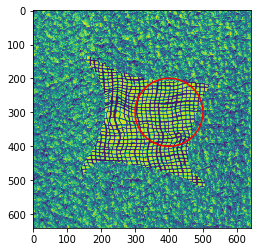

In [15]:
plt.imshow(img)
plt.plot(snake[:,0],snake[:,1],color='r')

In [16]:
# clustering of a sample of patches

index = random.sample(list(range(0,patches.shape[1])),20000)

sample = patches[:,index]

kmeans = KMeans(n_clusters=200,random_state=0).fit(sample.transpose())

(83, 163)


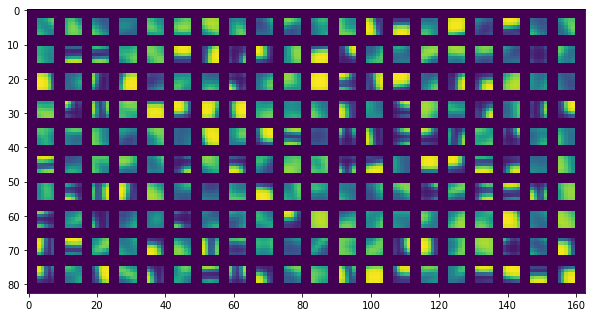

In [17]:
plot_dictionary(kmeans.cluster_centers_, 10,20)

In [18]:
snake_new, force, normals, prob_pred, mask_reduced, mask = deform(img, kmeans, index, patch_size, snake, 100)

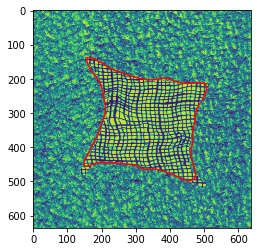

In [19]:
plt.imshow(img[int(patch_size/2):int(-(patch_size/2)),int(patch_size/2):int(-(patch_size/2))])
plt.plot(snake_new[:,0],snake_new[:,1],color='r')

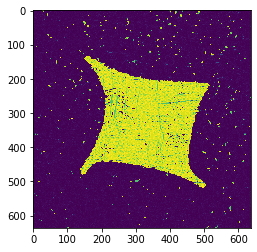

In [20]:
plt.imshow(prob_pred)

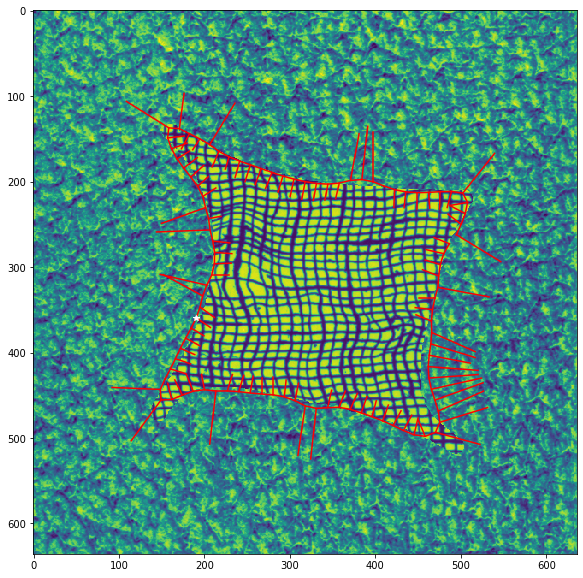

In [21]:
#plotting snake and force (obs force from previous iteration)

x_start = snake_new[:,0]
y_start = snake_new[:,1]

x_end = x_start + 100*force * normals[:,0]
y_end = y_start + 100*force * normals[:,1]

plt.figure(figsize=(10,10))
plt.imshow(img[int(patch_size/2):int(-(patch_size/2)),int(patch_size/2):int(-(patch_size/2))])
plt.plot(snake_new[:,0],snake_new[:,1],color='r')
plt.plot([x_start,x_end],[y_start,y_end],color='r');
plt.plot(snake_new[50,0],snake_new[50,1],'*w')
#plt.plot(snake[50,1],snake[50,0],'*b')

## Leopard

In [211]:
filename = 'data/134052.jpg'
img = skimage.io.imread(filename)
img = img.astype(np.float)
patches = ndim2col(img,[patch_size,patch_size],stepsize=1)

In [228]:
snake = init_snake(150,150,80,20)

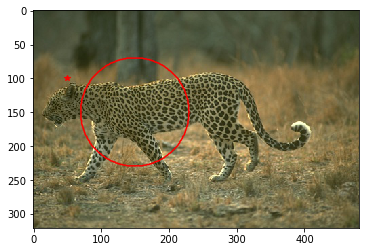

In [213]:
plt.imshow(img/255)
plt.plot(snake[:,0],snake[:,1],color='r')
plt.plot(50,100,'*r')

In [214]:
cv2.imshow('test',img.astype('uint8'))

In [215]:
# clustering of a sample of patches

index = random.sample(list(range(0,patches.shape[1])),10000)

sample = patches[:,index]

kmeans = KMeans(n_clusters=200,random_state=0).fit(sample.transpose())

(83, 163, 3)


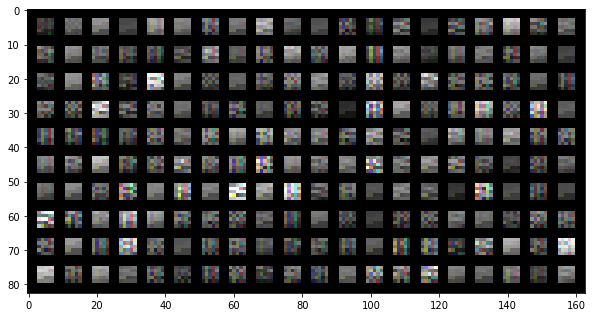

In [217]:
plot_dictionary(kmeans.cluster_centers_, 10,20, patch_shape=(5,5,3))

In [221]:
snake_new, force, normals, prob_pred, mask_reduced, mask = deform(img, kmeans, index, patch_size, snake, 1.5, 0.2, 10, 50)

In [222]:
snake_new, force, normals, prob_pred, mask_reduced, mask = deform(img, kmeans, index, patch_size, snake_new, 1, 0.2, 10, 50)

In [223]:
snake_new, force, normals, prob_pred, mask_reduced, mask = deform(img, kmeans, index, patch_size, snake_new, 0.5, 0.2, 10, 50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


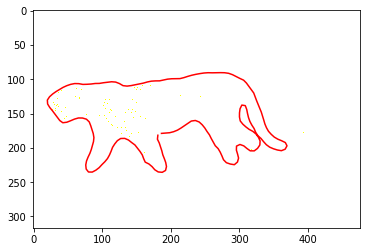

In [151]:
plt.imshow(img[int(patch_size/2):int(-(patch_size/2)),int(patch_size/2):int(-(patch_size/2))])
plt.plot(snake_new[:,0],snake_new[:,1],color='r')

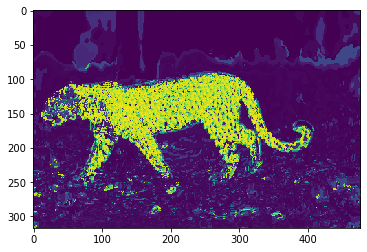

In [152]:
plt.imshow(prob_pred)

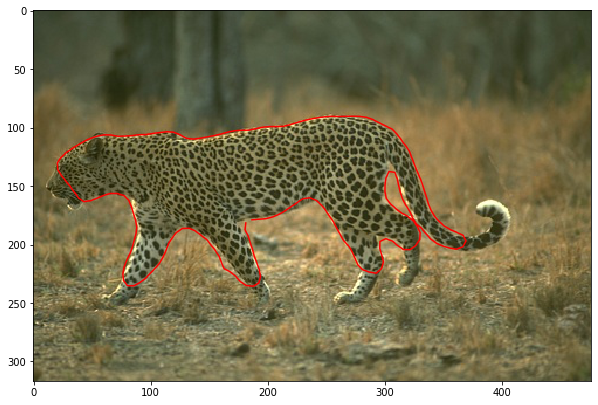

In [156]:
#plotting snake and force (obs force from previous iteration)

x_start = snake_new[:,0]
y_start = snake_new[:,1]

x_end = x_start + force * normals[:,0]
y_end = y_start + force * normals[:,1]

plt.figure(figsize=(10,10))
plt.imshow(img[int(patch_size/2):int(-(patch_size/2)),int(patch_size/2):int(-(patch_size/2))]/255)
plt.plot(snake_new[:,0],snake_new[:,1],color='r')
plt.plot([x_start,x_end],[y_start,y_end],color='r');
plt.plot(snake_new[50,0],snake_new[50,1],'*w')
#plt.plot(snake[50,1],snake[50,0],'*b')